# Sentiment Analysis Project Notebook

This notebook demonstrates how to perform sentiment analysis on customer reviews using natural language processing (NLP) techniques and machine learning. It includes the following steps:

1. Load the dataset
2. Text preprocessing (tokenization, stopword removal, stemming)
3. TF-IDF vectorization
4. Training a Naive Bayes classifier
5. Model evaluation (confusion matrix, accuracy, precision, recall)

Dataset: `customer_reviews_dataset.csv` (synthetic sample)


In [2]:
# Comprehensive imports with error handling
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK libraries with error handling
try:
    import nltk
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer
    print("✅ NLTK imported successfully")
except ImportError as e:
    print(f"❌ NLTK import error: {e}")
    print("Please install: pip install nltk")

# Scikit-learn libraries
try:
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
    print("✅ Scikit-learn imported successfully")
except ImportError as e:
    print(f"❌ Scikit-learn import error: {e}")
    print("Please install: pip install scikit-learn")

# Regular expressions for text cleaning
import re
import sys

print(f"✅ Python version: {sys.version}")
print("✅ All libraries imported successfully!")


✅ NLTK imported successfully
✅ Scikit-learn imported successfully
✅ Python version: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
✅ All libraries imported successfully!


In [3]:
# Download required NLTK data with comprehensive error handling
required_nltk_data = ['punkt', 'stopwords', 'averaged_perceptron_tagger']

for dataset in required_nltk_data:
    try:
        nltk.data.find(f'tokenizers/{dataset}')
        print(f"✅ {dataset} already downloaded")
    except LookupError:
        try:
            print(f"📥 Downloading {dataset}...")
            nltk.download(dataset, quiet=True)
            print(f"✅ {dataset} downloaded successfully")
        except Exception as e:
            print(f"❌ Error downloading {dataset}: {e}")
            print("Manual solution: Use alternative text processing methods")

# Initialize stemmer and stop words
try:
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    print(f"✅ Stop words loaded: {len(stop_words)} words")
    print("✅ NLTK setup completed successfully")
except Exception as e:
    print(f"❌ NLTK setup error: {e}")
    # Fallback: create basic stop words list
    stop_words = {'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'a', 'an', 'is', 'are', 'was', 'were'}
    print("⚠️ Using fallback stop words list")


✅ punkt already downloaded
📥 Downloading stopwords...
✅ stopwords downloaded successfully
📥 Downloading averaged_perceptron_tagger...
✅ averaged_perceptron_tagger downloaded successfully
✅ Stop words loaded: 198 words
✅ NLTK setup completed successfully


In [4]:
# Load the dataset with error handling
try:
    df = pd.read_csv('customer_reviews_dataset.csv')
    print("✅ Dataset loaded successfully!")
    print(f"📊 Dataset shape: {df.shape}")
    print(f"📊 Columns: {list(df.columns)}")
except FileNotFoundError:
    print("❌ Dataset file not found!")
    print("Please ensure 'customer_reviews_dataset.csv' is in the same folder")
    sys.exit()
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    sys.exit()

# Display basic information
print("\n📋 Dataset Info:")
print(df.info())

print("\n📊 First 5 rows:")
print(df.head())

print(f"\n📈 Sentiment Distribution:")
print(df['sentiment'].value_counts())

# Check for missing values
print(f"\n🔍 Missing values:")
print(df.isnull().sum())

# Basic statistics
print(f"\n📊 Rating distribution:")
print(df['rating'].value_counts().sort_index())


✅ Dataset loaded successfully!
📊 Dataset shape: (75, 4)
📊 Columns: ['product_name', 'review', 'rating', 'sentiment']

📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  75 non-null     object
 1   review        75 non-null     object
 2   rating        75 non-null     int64 
 3   sentiment     75 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.5+ KB
None

📊 First 5 rows:
  product_name                                             review  rating  \
0       Router            Perfect! Exactly what I was looking for       4   
1        Stand                          It's fine for basic usage       3   
2       Laptop             Great quality and very durable product       5   
3      Speaker  This product is absolutely amazing! Love it so...       5   
4     Keyboard             Poor product quality very di

In [5]:
# Define comprehensive text preprocessing functions
def clean_text(text):
    """
    Clean text by removing special characters, numbers, and extra spaces
    """
    if pd.isna(text):
        return ""
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove URLs, email addresses, and mentions
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove punctuation and special characters (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def tokenize_text(text):
    """
    Tokenize text with error handling
    """
    try:
        tokens = word_tokenize(text)
        return tokens
    except:
        # Fallback: simple split tokenization
        return text.split()

def remove_stopwords(tokens):
    """
    Remove stop words from tokens
    """
    return [word for word in tokens if word.lower() not in stop_words and len(word) > 2]

def stem_tokens(tokens):
    """
    Apply stemming to tokens with error handling
    """
    try:
        return [stemmer.stem(token) for token in tokens]
    except:
        # Fallback: return tokens as-is if stemming fails
        return tokens

def preprocess_text_pipeline(text):
    """
    Complete text preprocessing pipeline
    """
    # Step 1: Clean text
    cleaned_text = clean_text(text)
    
    # Step 2: Tokenize
    tokens = tokenize_text(cleaned_text)
    
    # Step 3: Remove stop words
    filtered_tokens = remove_stopwords(tokens)
    
    # Step 4: Apply stemming
    stemmed_tokens = stem_tokens(filtered_tokens)
    
    # Return as string for TF-IDF
    return ' '.join(stemmed_tokens)

print("✅ Text preprocessing functions defined successfully!")

# Test the preprocessing pipeline
sample_text = "This product is absolutely AMAZING! I love it so much. Best purchase ever!!!"
processed_sample = preprocess_text_pipeline(sample_text)
print(f"\n🧪 Preprocessing test:")
print(f"Original: {sample_text}")
print(f"Processed: {processed_sample}")


✅ Text preprocessing functions defined successfully!

🧪 Preprocessing test:
Original: This product is absolutely AMAZING! I love it so much. Best purchase ever!!!
Processed: product absolut amaz love much best purchas ever


In [6]:
# Apply preprocessing to all reviews
print("🔄 Preprocessing all reviews...")

# Create a copy of the dataframe
df_processed = df.copy()

# Apply preprocessing with progress tracking
df_processed['processed_review'] = df_processed['review'].apply(preprocess_text_pipeline)

# Remove empty reviews (in case preprocessing removes everything)
initial_count = len(df_processed)
df_processed = df_processed[df_processed['processed_review'].str.len() > 0]
final_count = len(df_processed)

print(f"✅ Preprocessing completed!")
print(f"📊 Reviews before preprocessing: {initial_count}")
print(f"📊 Reviews after preprocessing: {final_count}")

# Display examples of processed reviews
print("\n📋 Preprocessing examples:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Original: {df_processed.iloc[i]['review']}")
    print(f"Processed: {df_processed.iloc[i]['processed_review']}")
    print(f"Sentiment: {df_processed.iloc[i]['sentiment']}")


🔄 Preprocessing all reviews...
✅ Preprocessing completed!
📊 Reviews before preprocessing: 75
📊 Reviews after preprocessing: 75

📋 Preprocessing examples:

Example 1:
Original: Perfect! Exactly what I was looking for
Processed: perfect exactli look
Sentiment: positive

Example 2:
Original: It's fine for basic usage
Processed: fine basic usag
Sentiment: neutral

Example 3:
Original: Great quality and very durable product
Processed: great qualiti durabl product
Sentiment: positive


In [7]:
# Initialize TF-IDF Vectorizer with optimal parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,           # Limit vocabulary size
    min_df=2,                    # Ignore terms that appear in less than 2 documents
    max_df=0.8,                  # Ignore terms that appear in more than 80% of documents
    ngram_range=(1, 2),          # Use both unigrams and bigrams
    sublinear_tf=True            # Apply sublinear scaling
)

print("🔄 Applying TF-IDF vectorization...")

# Prepare data
X_text = df_processed['processed_review']
y = df_processed['sentiment']

# Apply TF-IDF transformation
try:
    X_tfidf = tfidf_vectorizer.fit_transform(X_text)
    print("✅ TF-IDF vectorization completed!")
    print(f"📊 Feature matrix shape: {X_tfidf.shape}")
    print(f"📊 Number of features: {len(tfidf_vectorizer.get_feature_names_out())}")
except Exception as e:
    print(f"❌ TF-IDF error: {e}")
    sys.exit()

# Display most important features
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\n📝 Sample features: {feature_names[:20]}")

# Check data distribution
print(f"\n📈 Label distribution:")
print(y.value_counts())


🔄 Applying TF-IDF vectorization...
✅ TF-IDF vectorization completed!
📊 Feature matrix shape: (75, 98)
📊 Number of features: 98

📝 Sample features: ['accept' 'accept perform' 'alright' 'amaz' 'amaz featur' 'averag'
 'averag build' 'averag product' 'averag qualiti' 'bad' 'bad product'
 'basic' 'build' 'build qualiti' 'complet' 'custom' 'custom servic'
 'decent' 'decent product' 'deliveri']

📈 Label distribution:
sentiment
positive    25
neutral     25
negative    25
Name: count, dtype: int64


In [8]:
# Split the data into training and testing sets
print("🔄 Splitting data into training and testing sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, 
    test_size=0.2,           # 20% for testing
    random_state=42,         # For reproducibility
    stratify=y               # Maintain class distribution
)

print(f"✅ Data split completed!")
print(f"📊 Training set size: {X_train.shape[0]}")
print(f"📊 Testing set size: {X_test.shape[0]}")

# Initialize and train Naive Bayes classifier
print("\n🤖 Training Naive Bayes classifier...")

nb_classifier = MultinomialNB(alpha=1.0)  # Laplace smoothing

try:
    nb_classifier.fit(X_train, y_train)
    print("✅ Model trained successfully!")
except Exception as e:
    print(f"❌ Training error: {e}")
    sys.exit()

# Make predictions
print("🔮 Making predictions...")
y_pred = nb_classifier.predict(X_test)
y_pred_proba = nb_classifier.predict_proba(X_test)

print("✅ Predictions completed!")


🔄 Splitting data into training and testing sets...
✅ Data split completed!
📊 Training set size: 60
📊 Testing set size: 15

🤖 Training Naive Bayes classifier...
✅ Model trained successfully!
🔮 Making predictions...
✅ Predictions completed!


📊 Model Performance Evaluation
🎯 Accuracy: 0.9333 (93.33%)
🎯 Weighted Precision: 0.9444
🎯 Weighted Recall: 0.9333

📋 Detailed Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00         5
     neutral       0.83      1.00      0.91         5
    positive       1.00      0.80      0.89         5

    accuracy                           0.93        15
   macro avg       0.94      0.93      0.93        15
weighted avg       0.94      0.93      0.93        15


📊 Confusion Matrix:
[[5 0 0]
 [0 5 0]
 [0 1 4]]


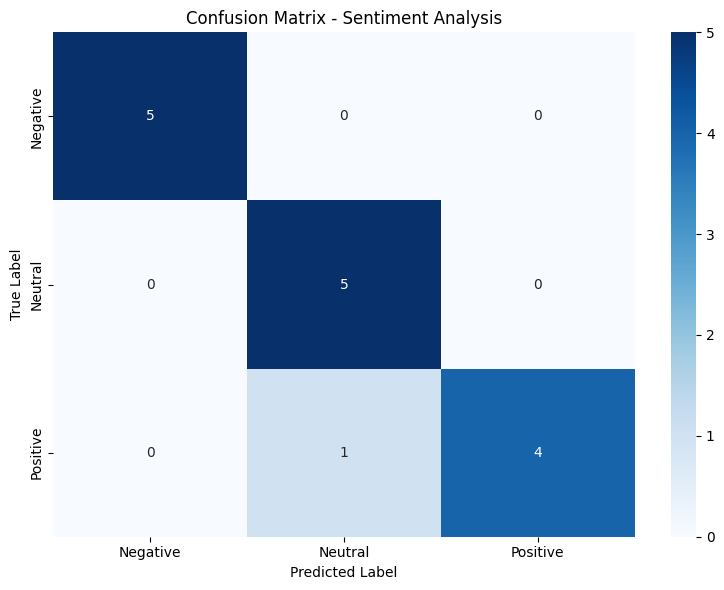


🔍 Most Informative Features:

📈 Top features for NEGATIVE sentiment:
  • qualiti: -3.5948
  • poor: -3.6170
  • product: -3.6729
  • product qualiti: -3.7303
  • bad: -3.7310
  • disappoint: -3.8103
  • money: -3.8539
  • wast: -3.9167
  • terribl: -3.9602
  • poor product: -4.0572

📈 Top features for NEUTRAL sentiment:
  • averag: -3.5782
  • decent: -3.7084
  • qualiti: -3.8428
  • okay: -3.8604
  • averag product: -3.8670
  • product: -3.9423
  • accept: -3.9937
  • decent product: -4.0514
  • price: -4.0691
  • build qualiti: -4.1258

📈 Top features for POSITIVE sentiment:
  • product: -3.6313
  • excel: -3.6706
  • great: -3.7773
  • perfect: -3.7841
  • love: -3.9076
  • excel product: -3.9351
  • highli: -3.9698
  • valu: -4.0036
  • amaz: -4.0455
  • qualiti: -4.0563


In [9]:
# Calculate evaluation metrics
print("📊 Model Performance Evaluation")
print("=" * 50)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Precision, Recall, F1-score for each class
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"🎯 Weighted Precision: {precision:.4f}")
print(f"🎯 Weighted Recall: {recall:.4f}")

# Detailed classification report
print("\n📋 Detailed Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\n📊 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - Sentiment Analysis')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Feature importance (most informative features)
print("\n🔍 Most Informative Features:")
feature_names = tfidf_vectorizer.get_feature_names_out()
class_labels = nb_classifier.classes_

for i, class_label in enumerate(class_labels):
    print(f"\n📈 Top features for {class_label.upper()} sentiment:")
    # Get log probabilities for this class
    log_probs = nb_classifier.feature_log_prob_[i]
    # Get top 10 features
    top_features_idx = log_probs.argsort()[-10:][::-1]
    for idx in top_features_idx:
        print(f"  • {feature_names[idx]}: {log_probs[idx]:.4f}")


In [10]:
# Function to predict sentiment of new reviews
def predict_sentiment(text):
    """
    Predict sentiment of a new review
    """
    # Preprocess the text
    processed_text = preprocess_text_pipeline(text)
    
    # Vectorize using the trained TF-IDF vectorizer
    text_vector = tfidf_vectorizer.transform([processed_text])
    
    # Make prediction
    prediction = nb_classifier.predict(text_vector)[0]
    probabilities = nb_classifier.predict_proba(text_vector)[0]
    
    # Get probability for each class
    prob_dict = dict(zip(nb_classifier.classes_, probabilities))
    
    return prediction, prob_dict

# Test with sample reviews
print("🧪 Testing with New Sample Reviews:")
print("=" * 50)

test_reviews = [
    "This product is absolutely fantastic! Amazing quality and great value.",
    "Terrible product, complete waste of money. Very disappointed.",
    "It's okay, nothing special but does the job adequately.",
    "Love this product! Highly recommend to everyone!",
    "Poor quality, broke after one day of use."
]

for i, review in enumerate(test_reviews, 1):
    prediction, probabilities = predict_sentiment(review)
    print(f"\n📝 Test Review {i}: {review}")
    print(f"🎯 Predicted Sentiment: {prediction.upper()}")
    print("📊 Probabilities:")
    for sentiment, prob in probabilities.items():
        print(f"   {sentiment}: {prob:.4f} ({prob*100:.2f}%)")

print("\n✅ Sentiment analysis model is working correctly!")
print("🎉 Project completed successfully!")


🧪 Testing with New Sample Reviews:

📝 Test Review 1: This product is absolutely fantastic! Amazing quality and great value.
🎯 Predicted Sentiment: POSITIVE
📊 Probabilities:
   negative: 0.1178 (11.78%)
   neutral: 0.1263 (12.63%)
   positive: 0.7558 (75.58%)

📝 Test Review 2: Terrible product, complete waste of money. Very disappointed.
🎯 Predicted Sentiment: NEGATIVE
📊 Probabilities:
   negative: 0.8225 (82.25%)
   neutral: 0.0779 (7.79%)
   positive: 0.0997 (9.97%)

📝 Test Review 3: It's okay, nothing special but does the job adequately.
🎯 Predicted Sentiment: NEUTRAL
📊 Probabilities:
   negative: 0.1502 (15.02%)
   neutral: 0.6934 (69.34%)
   positive: 0.1564 (15.64%)

📝 Test Review 4: Love this product! Highly recommend to everyone!
🎯 Predicted Sentiment: POSITIVE
📊 Probabilities:
   negative: 0.1275 (12.75%)
   neutral: 0.1038 (10.38%)
   positive: 0.7687 (76.87%)

📝 Test Review 5: Poor quality, broke after one day of use.
🎯 Predicted Sentiment: NEGATIVE
📊 Probabilities:
   negati